### **Modelling Assignment 3 (Group Component)**
Group 17: Raihan Arvi, Parsa Nayyara, Malcolm Maxwell

### **Prompt**
*Construct a linear regression model to predict the duration of sleep from the other columns in sleep.csv, with data for 374 people. In your model construction, you may find it necessary to “transform” some of the variables. Determine the best linear regression model to predict the Sleep Duration. If you choose a model with transformed variables, it is expected that you will compare the transformed model results with the results from a standard multiple linear regression (i.e., without transformed data). Be sure to clearly state which linear regression your group deems to be the ‘best’ and explain why you have chosen this model. Be sure to mention how duration may be dependent on the mattress and pillow used.*

*Note: Since some of the data is ranked on a scale of 1 to 10, we will see “columns” of data points when looking at some of the diagnostic plots at the integer or half-integer values (i.e., the points on the rank scale). In these cases, when we are looking for “random scatter”, we look vertically in the column to see if the points have any pattern and to see if the points are “equally” distributed over the horizontal y = 0 line (if applicable). If we do not see a equal distribution in the columns of the plots, then we may be concerned that one (or more) of the linear regression assumptions are violated. Be sure to mention how diagnostic plots resulting from covariates that are on Likert scales can be challenging to interpret. Use all of the data to construct the linear regression model.*


### **1. Problem Statement**

To construct a linear regression model to relate sleep duration from sleep quality, physical activity during the day, and stress level; and compare transformed model vs standard multiple linear regression.

### **2. Variables and Parameters** <br>

**Variables**

| Type                  | Description               |Symbol |  Dimension | Unit  |
|-----------------------|---------------------------|-----------|-----------|-------|
| Independent variable  | Physical Activity during day                   | $x_1$ | 1         | 1  |
| Independent variable  | Stress Level      | $x_2$ | 1         | minutes/day  |
| Independent variable  | Quality of sleep                      | $x_3$ | 1         | 1  |
| Dependent variable  | Sleep Duration                      | $y$ | T         | hours  |

</br>

**Parameters**
| Type | Description | Symbol | Dimension | Value    | Unit |
|------|-------------|--------|-----------|----------|------|
| Parameter | Constant Coefficient | $\beta_0$ | T |  | hours 
| Parameter | Change in sleep duration per one unit change in physical activity | $\beta_1$ | T |  | hours 
| Parameter | Change in sleep duration per one unit change in stress level | $\beta_2$ | T |  | 60 $\cdot$ day 
| Parameter | Change in sleep duration per one unit change in sleep quality | $\beta_3$ | T |  | hours 
| Parameter | Residual | $\epsilon$ | T |  | hours

### **3. Assumptions and Constraints**

*   The model follows a linear model (shown below)
*   Average value of the error is zero, $\mathbb{E}(\epsilon_i) = 0$ for all $i$
*   Variance is constant, $\textrm{var}(\epsilon_i) = \sigma^2$ for all $i$
*   Errors are normally distributed
*   Errors are independent, $\epsilon_i$ for all $i$
*   Data collected are measured reliably, no systematic error
*   There are no other factors that impact the target variable other the the ones listed

### **4. Build Solution**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv("Sleep.csv")
df.head()

,Duration,Quality,Physical_Activity,Stress
0,6.1,6,42,6
1,6.2,6,60,8
2,6.2,6,60,8
3,5.9,4,30,8
4,5.9,4,30,8


</br>
We need to check first what the data looks like to estimate what kind of transformation is needed on the data before performing linear regression. 
</br>

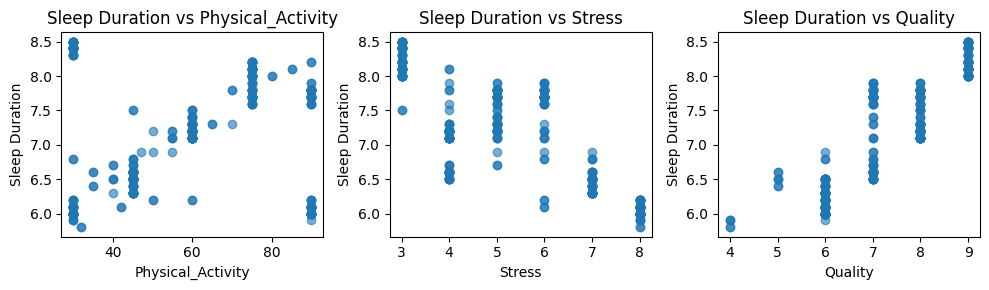

In [3]:
# Duration vs. each predictor
response = "Duration"
predictors = ["Physical_Activity", "Stress", "Quality"]

fig, axes = plt.subplots(1, len(predictors), figsize=(10, 3))

for ax, pred in zip(axes, predictors):
    x = df[pred].values
    y = df[response].values

    ax.scatter(x, y, alpha=0.6)

    ax.set_xlabel(pred)
    ax.set_ylabel("Sleep Duration")
    ax.set_title(f"Sleep Duration vs {pred}")

plt.tight_layout()
plt.show()

#### Baseline Model

Our baseline linear regression model is given by

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon, $$

where $y$ is sleep duration, $x_1$ is physical activity, $x_2$ is stress level, $x_{3}$ is sleep quality, $\beta$ are the beta parameters as shown in our parameters table, and $\epsilon$ is the residual. Independent variables are not transformed in the baseline model and reflect the actual data in sleep.csv.
</br>

In [4]:
# baseline model
X_baseline = sm.add_constant(df[["Physical_Activity","Stress","Quality"]])
Y_baseline = df["Duration"]

model_baseline = sm.OLS(Y_baseline, X_baseline).fit()
print("Baseline Model:")
print(model_baseline.summary())
print(f"Adjusted R^2 (baseline): {model_baseline.rsquared_adj:.5f}")

Baseline Model:
                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     450.5
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          4.13e-123
Time:                        22:28:24   Log-Likelihood:                -157.20
No. Observations:                 374   AIC:                             322.4
Df Residuals:                     370   BIC:                             338.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 

#### Transformed Model

To assess which data transformation strategy would result in ${R^{2}}_{adj}$ closest to 1, we did iterative linear regression on each of the six possible transformations. We then rank the ${R^{2}}_{adj}$ to determine which data transformations we want to perform in our final transformed model.
</br>

In [5]:
transform_list = [
    ("Stress Level square root",      "predictor", "Stress", lambda s: np.sqrt(s)),
    ("Stress Level squared",        "predictor", "Stress", lambda s: s**2),
    ("Sleep Quality log",      "predictor", "Quality", lambda s: np.log(s)),
    ("Sleep Quality squared",       "predictor", "Quality", lambda s: s**2),
    ("Sleep Duration log",     "response",  "Duration", lambda s: np.log(s)),
    ("Sleep Duration square root",    "response",  "Duration", lambda s: np.sqrt(s)),
]

results = []
for name, kind, col, func in transform_list:

    temp = df[['Duration','Physical_Activity','Stress','Quality']].copy()

    if func is np.log:
        temp[col] = temp[col].where(temp[col] > 0, np.nan).map(lambda v: np.log(v) if pd.notna(v) else np.nan)
    else:
        temp[col] = func(temp[col].astype(float))
    temp = temp.dropna(subset=['Duration','Physical_Activity','Stress','Quality'])

    X_t = sm.add_constant(temp[['Physical_Activity','Stress','Quality']])
    if kind == "response":
        Y_t = temp['Duration'] if col != 'Duration' else temp['Duration']  
    if kind == "response":
        Y_t = temp[col]   
    else:
        Y_t = temp['Duration']  

    m = sm.OLS(Y_t, X_t).fit()
    results.append((name, len(temp), m.rsquared_adj))

res_df = pd.DataFrame(results, columns=['transformation','n_obs','adj_R2']).sort_values('adj_R2', ascending=False)
print("\n\n=== Summary (ranked by adj. R^2) ===")
display(res_df.reset_index(drop=True))



=== Summary (ranked by adj. R^2) ===


,transformation,n_obs,adj_R2
0,Sleep Quality squared,374,0.795499
1,Sleep Duration log,374,0.789244
2,Sleep Duration square root,374,0.786617
3,Stress Level squared,374,0.786230
4,Stress Level square root,374,0.782382
5,Sleep Quality log,374,0.761036


</br>
We observed that taking the square of the Sleep Quality scores and the natural log of Sleep Duration give the largest ${R^{2}}_{adj}$. We chose to do these two transformations in our next model.
</br>

</br>
Our transformed linear regression model is given by

$$ y_{trans} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_{3,  trans} + \epsilon, $$

where $y_{trans}$ is the natural log of sleep duration, $x_1$ is physical activity, $x_2$ is stress level, $x_{3,  trans}$ is sleep quality squared, $\beta$ are the beta parameters as shown in our parameters table, and $\epsilon$ is the residual.
</br>

In [6]:
# prepare a working copy and create transforms
temp = df[['Duration','Physical_Activity','Stress','Quality']].copy()
temp['Quality_sq'] = temp['Quality'].astype(float) ** 2
temp['log_Duration'] = np.log(temp['Duration'].astype(float))

X = sm.add_constant(temp[['Physical_Activity','Stress','Quality_sq']])
Y = temp['log_Duration']

model = sm.OLS(Y, X).fit()
print(model.summary())

print(f"\nAdjusted R^2: {model.rsquared_adj:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_Duration   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     489.6
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          2.07e-128
Time:                        22:28:24   Log-Likelihood:                 587.63
No. Observations:                 374   AIC:                            -1167.
Df Residuals:                     370   BIC:                            -1152.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7052      0.03

</br>
We saw an improvement in the ${R^{2}}_{adj}$ after transforming sleep duration and sleep quality data. We were curious to see if transforming one other variable would increase ${R^{2}}_{adj}$ even more. We chose to transform .... ranking. In this final transformed model, we transformed sleep duration, sleep quality, and stress level. 

</br>
Our final transformed linear regression model is given by

$$ y_{trans} = \beta_0 + \beta_1 x_1 + \beta_2 x_{2, trans} + \beta_3 x_{3,  trans} + \epsilon, $$

where $y_{trans}$ is the natural log of sleep duration, $x_1$ is physical activity, $x_{2, trans}$ is stress level squared, $x_{3,  trans}$ is sleep quality squared, $\beta$ are the beta parameters as shown in our parameters table, and $\epsilon$ is the residual.
</br>

In [7]:
# transformed model

df["Stress_sq"] = df["Stress"]**2
df["Quality_sq"] = df["Quality"]**2
df["log_Duration"] = np.log(df["Duration"])

X_transform = sm.add_constant(df[["Physical_Activity","Stress_sq","Quality_sq"]])
Y_transform = df["log_Duration"]

model_trans = sm.OLS(Y_transform, X_transform).fit()
print("Transformed Model:")
print(model_trans.summary())
print(f"Adjusted R^2 (transformed): {model_trans.rsquared_adj:.5f}")

Transformed Model:
                            OLS Regression Results                            
Dep. Variable:           log_Duration   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     509.4
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          5.78e-131
Time:                        22:28:24   Log-Likelihood:                 593.57
No. Observations:                 374   AIC:                            -1179.
Df Residuals:                     370   BIC:                            -1163.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              

#### Check 4 Linear Regression Assumptions for Transformed Model

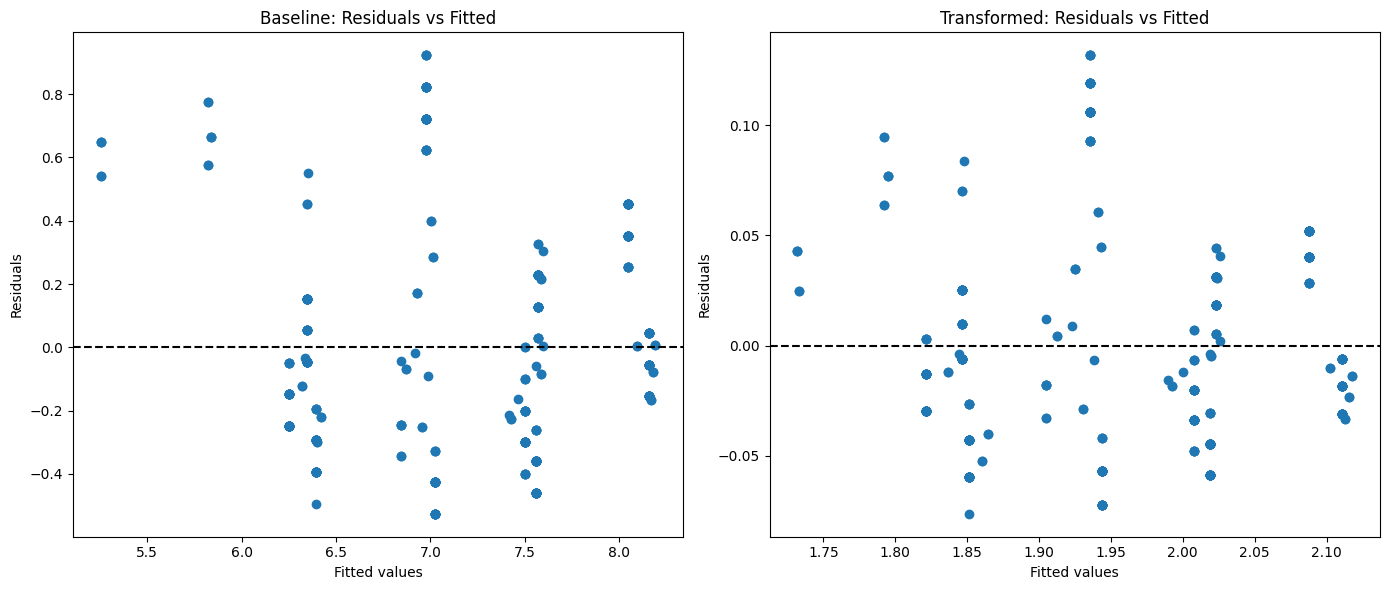

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# baseline
ax0 = axes[0]
ax0.scatter(model_baseline.fittedvalues, model_baseline.resid)
ax0.axhline(y = 0, color = 'k', linestyle = '--')
ax0.set_xlabel("Fitted values")
ax0.set_ylabel("Residuals")
ax0.set_title("Baseline: Residuals vs Fitted")

# transformed
ax1 = axes[1]
ax1.scatter(model_trans.fittedvalues, model_trans.resid)
ax1.axhline(y = 0, color = 'k', linestyle = '--')
ax1.set_xlabel("Fitted values")
ax1.set_ylabel("Residuals")
ax1.set_title("Transformed: Residuals vs Fitted")

plt.tight_layout()
plt.show()

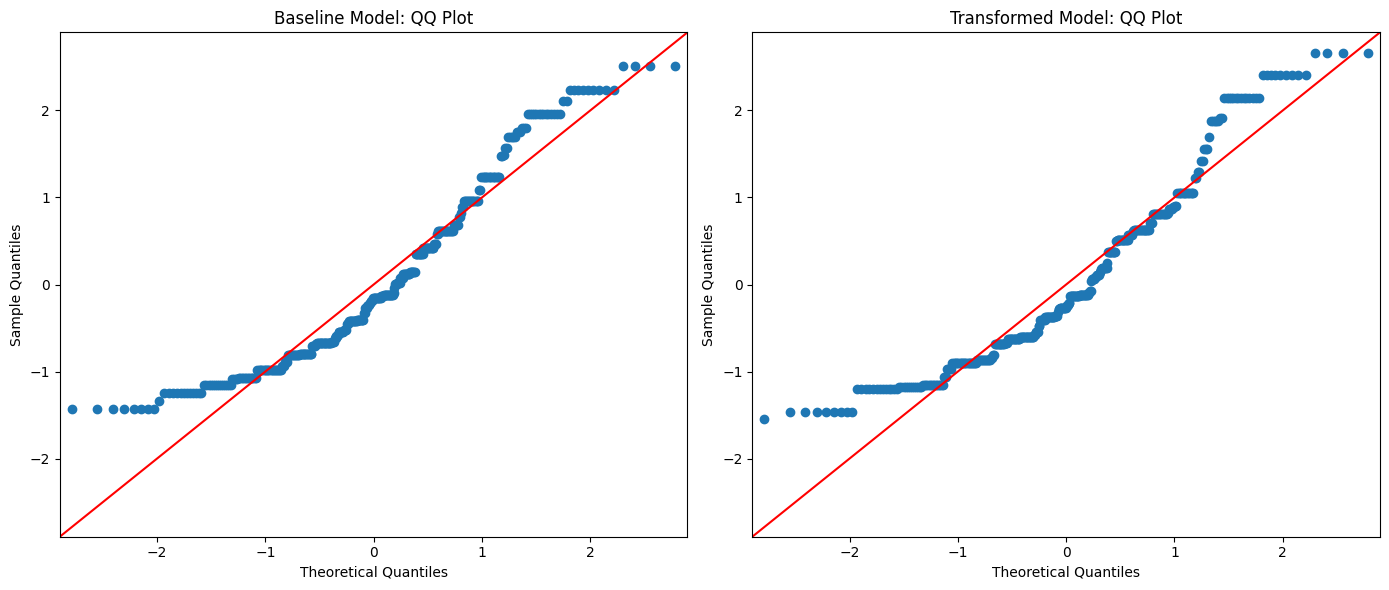

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# baseline
ax0 = axes[0]
sm.qqplot(model_baseline.resid, line='45', fit=True, ax=ax0)
ax0.set_title("Baseline Model: QQ Plot")

# transformed
ax1 = axes[1]
sm.qqplot(model_trans.resid, line='45', fit=True, ax=ax1)
ax1.set_title("Transformed Model: QQ Plot")

plt.tight_layout()
plt.show()

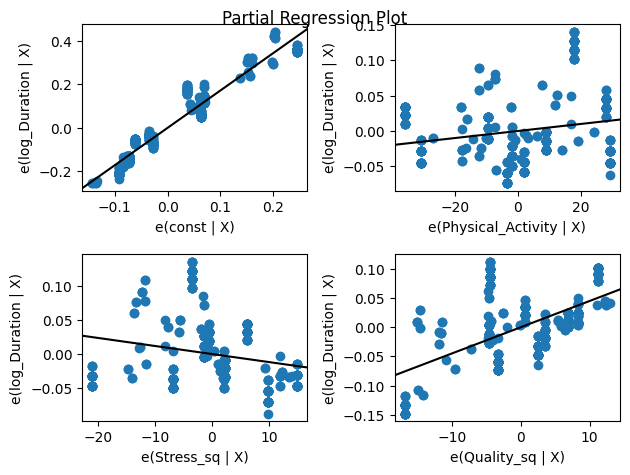

In [10]:
fig = sm.graphics.plot_partregress_grid(model_trans)
plt.show()

### **5. Discussion & Analysis**

We checked the 4 linear regression assumptions for both the baseline and the transformed model. 

Be sure to clearly state which linear regression your group deems to be the ‘best’ and explain why you have chosen this model. Be sure to mention how duration may be dependent on the mattress and pillow used.*

Determine if the linear regression assumptions are satisfied.
Determine the best model to predict the output variable.
Compute values derived from the linear regression